In [1]:
import ipywidgets as ipw
from IPython.display import display
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np

from stochastic_models import model_sir
from stochastic_tests import Test
import sim_lib

t_fin = 10.0
num_steps = 200
periods = list(range(1, 5)) + [10, 100, 1000]
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   trials=[100, 1000, 10000], 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)])

test_template = Test(model=model_sir({'beta': ('norm', (2.0E-6, 0.2E-6))}), stochastic=False, **test_kwargs)

_ = sim_lib.start_pool()

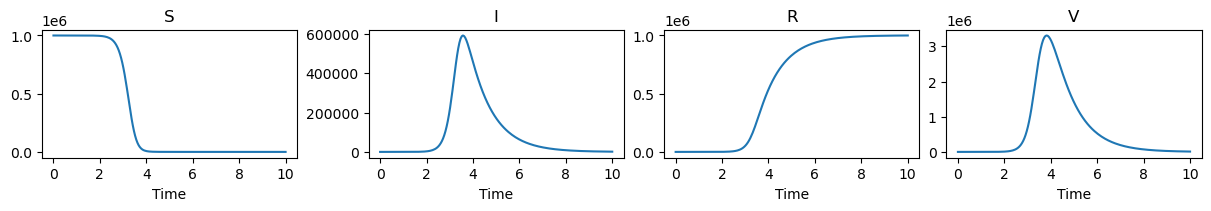

In [2]:
test_template.execute_deterministic()
_ = test_template.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

test_template.execute_stochastic(label)
_ = out.clear_output()

Output()

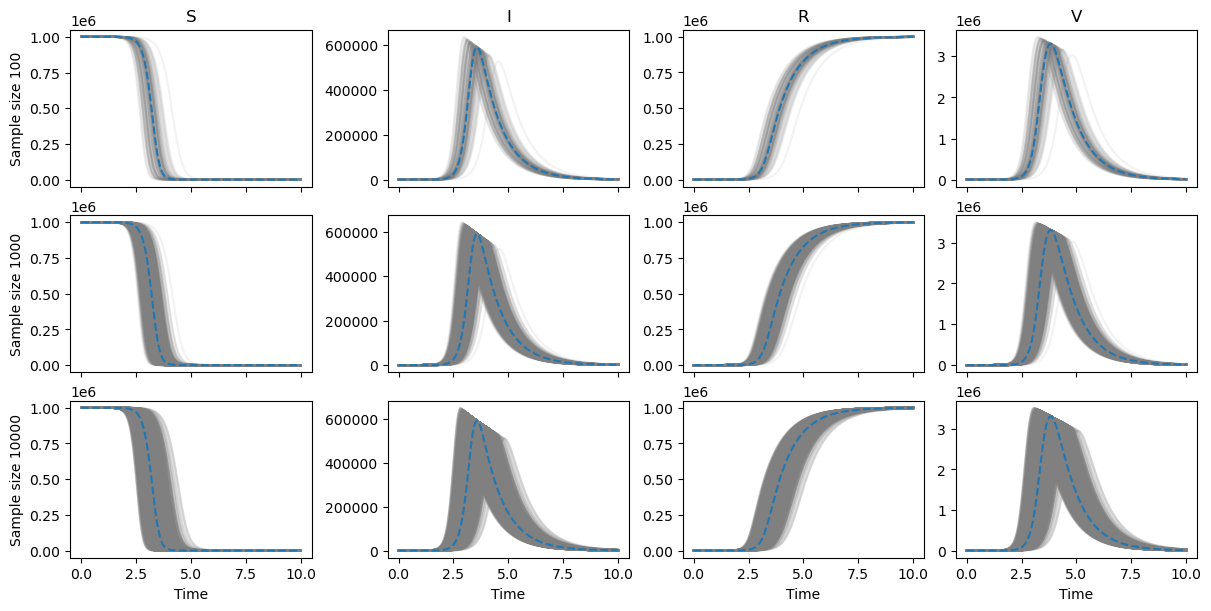

In [4]:
_ = test_template.plot_results_stochastic()

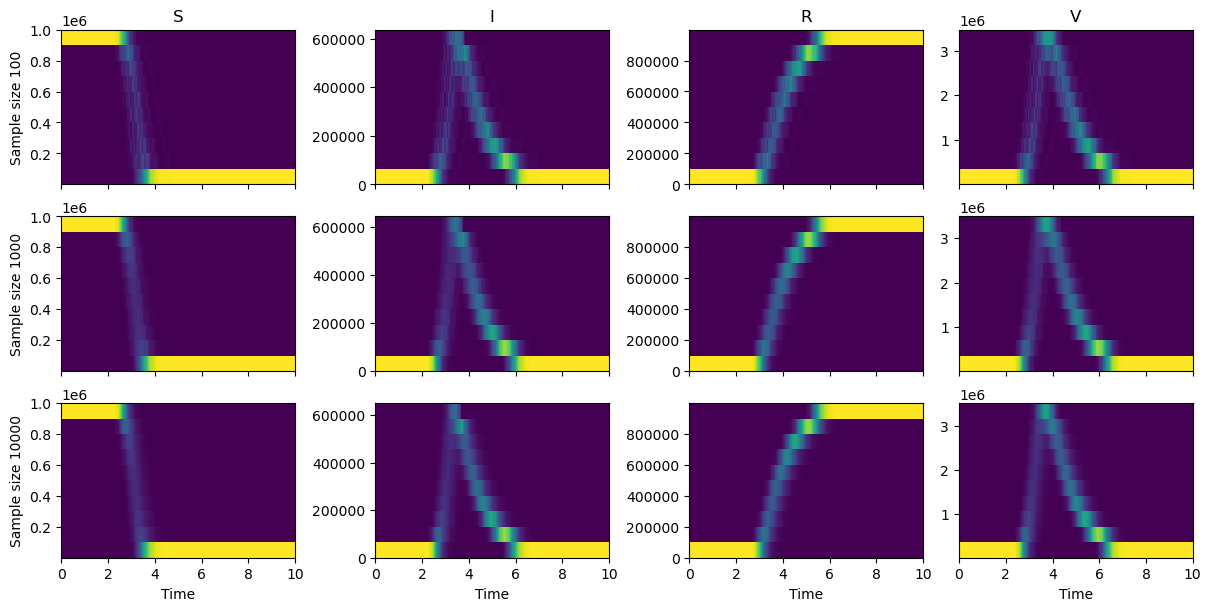

In [5]:
_ = test_template.plot_distributions()

In [6]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)


def eval_by_num_periods(_test: Test, _num_periods: int):
    label.value = f'Periods: {_num_periods}... '
    test = _test.clone()
    test.num_var_pers = _num_periods
    label.value += 'Finding ECFs... '
    test.find_ecfs()
    label.value += 'Finding differences... '
    test.measure_ecf_diffs()
    label.value += 'Testing samples... '
    test.test_sampling(err_thresh=1E-3)
    label.value += 'Generating fits... '
    test.generate_ecf_sampling_fits()
    _ = out.clear_output()
    return test


tests = {i: eval_by_num_periods(test_template, i) for i in periods}

Output()

/home/timothy.sego/PycharmProjects/ssr_project_2024/code/stochastic_repro.py:994: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(fit_func, data_x, data_y, **kwargs)


Show how identifying features of the empirical characterstic function are lost when the transform variable domain is too large.

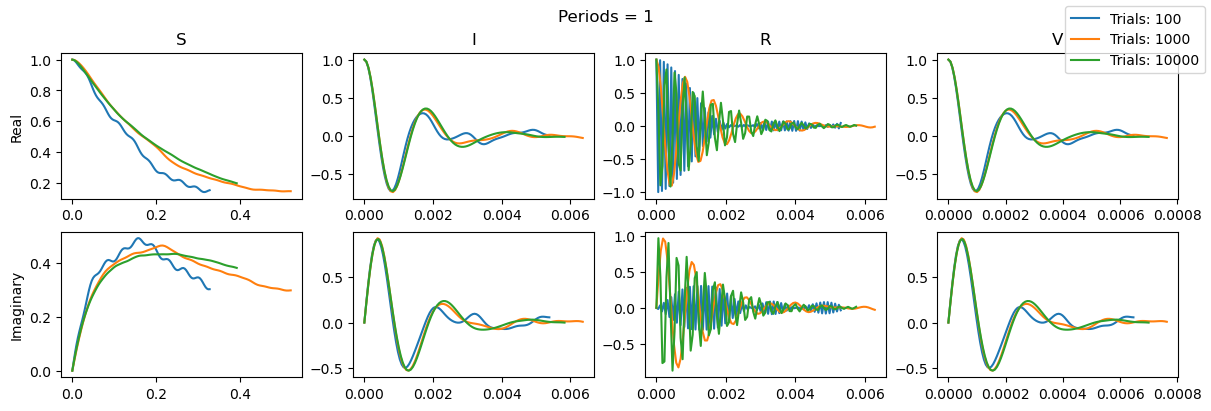

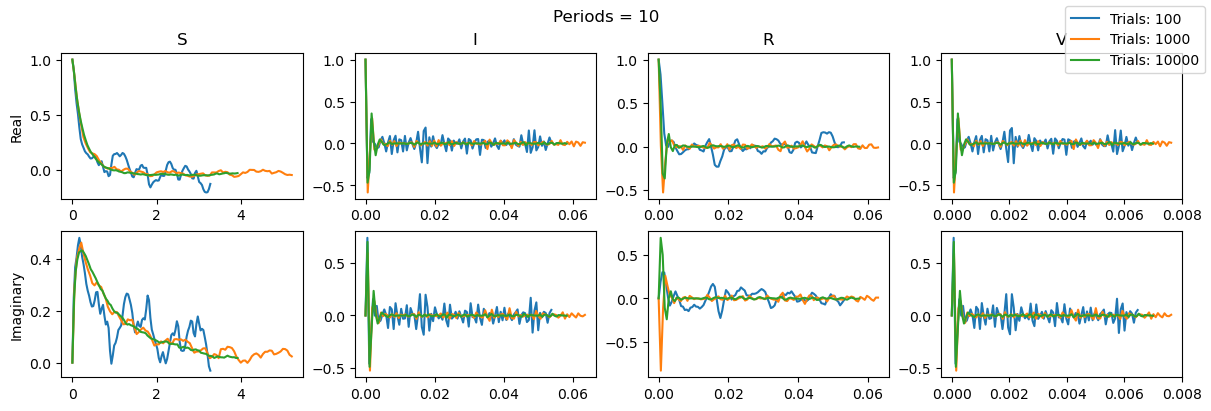

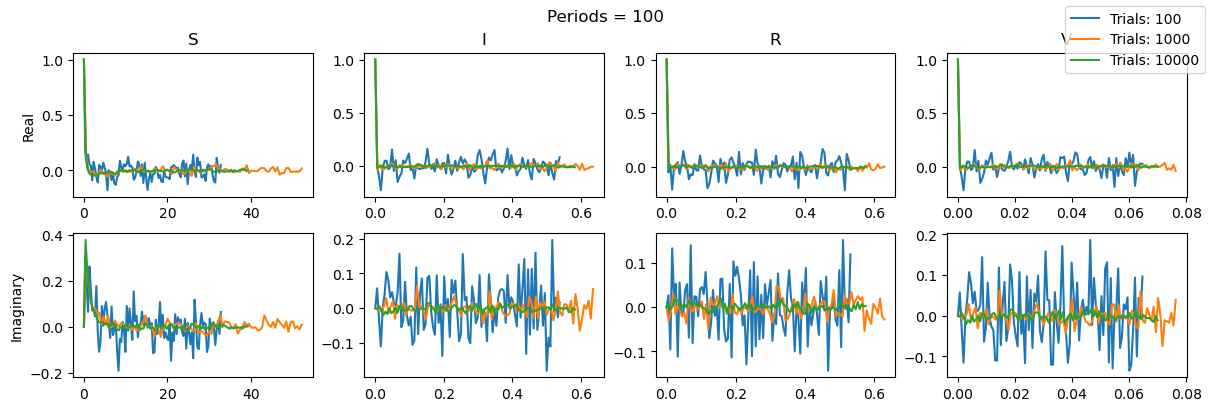

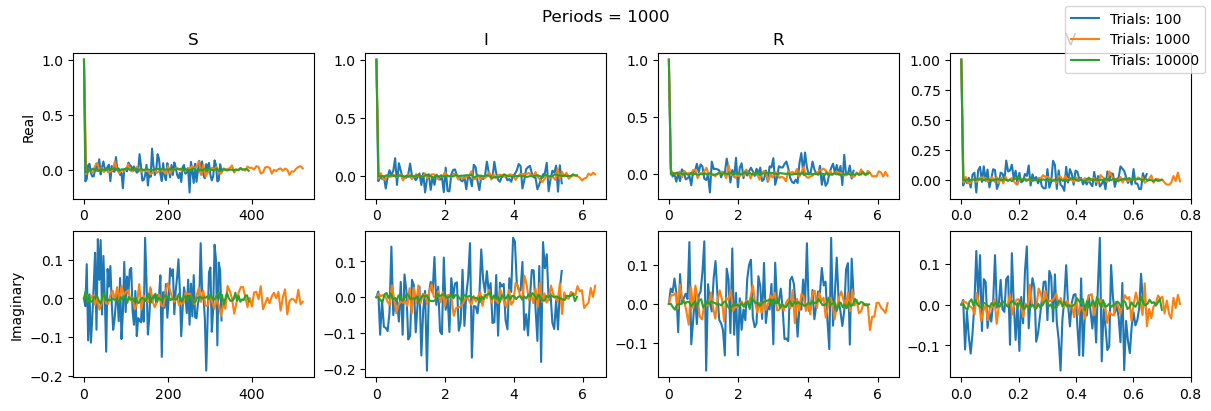

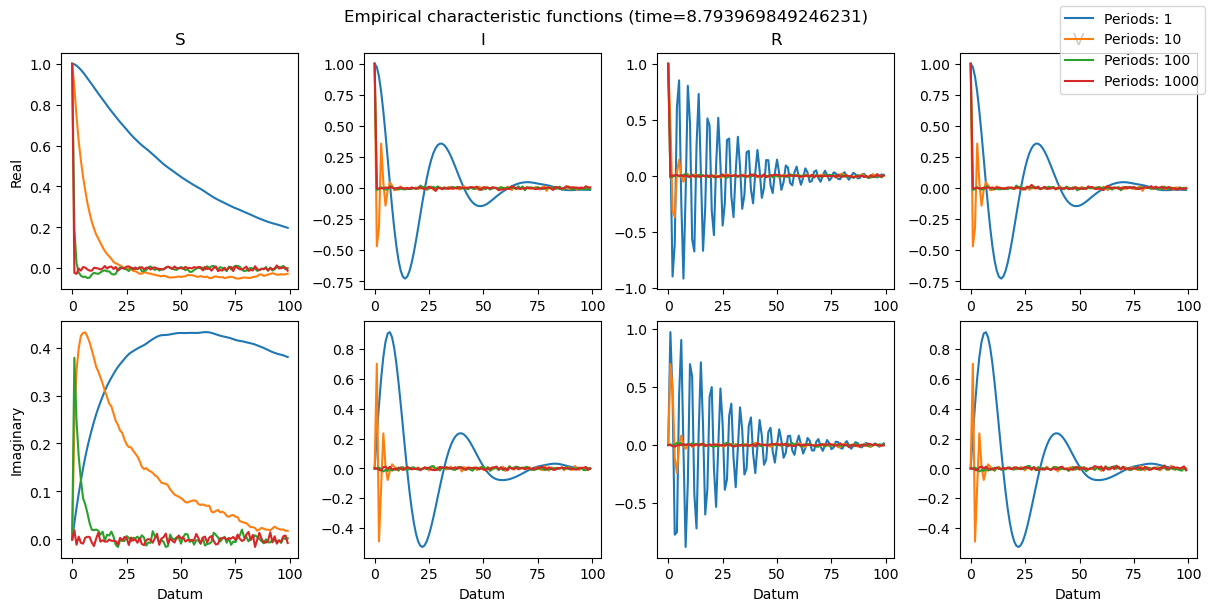

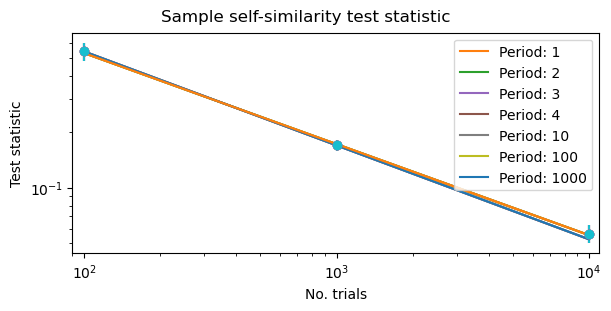

In [7]:
periods_oi = [1, 10, 100, 1000]
time_oi = tests[periods_oi[0]].max_ks_stat_time(tests[periods_oi[0]].trials[-1])
for i in periods_oi:
    test = tests[i]
    fig, ax = test.plot_ecf(time=time_oi)
    fig.suptitle(f'Periods = {i}')


def plot_ecf_sampling(_test: Test, fig=None, ax=None):
    avg = np.asarray([_test.ecf_sampling[t][0] for t in _test.trials], dtype=float)
    std = np.asarray([_test.ecf_sampling[t][1] for t in _test.trials], dtype=float)
    if ax is None:
        ax = fig.subplots(1, 1)
    ax.errorbar(_test.trials, avg, yerr=std, marker='o', linestyle='none')
    ax.set_xlabel('No. trials')
    ax.set_ylabel('Test statistic')
    ax.set_xscale('log')
    ax.set_yscale('log')

    for i, data_f in enumerate(_test.ecf_sampling_fits[0]):
        if data_f is not None:
            ax.plot(_test.trials, [Test.ecf_diff_fit_func(n, *data_f) for n in _test.trials], label=f'Sample size {_test.trials[i+1]}')

    return fig, ax


fig_ax = plt.subplots(2, len(test_template.model.results_names), figsize=(12.0, 6.0), layout='compressed')
for i in periods_oi:
    test = tests[i]

    trial = test.trials[-1]

    idx = test.sims_s[trial].get_time_index(time_oi)
    for j, name in enumerate(test.model.results_names):
        ecfs = test.ecf[trial][idx][name]
        eval_times = list(range(len(ecfs[:, 0])))
        fig_ax[1][0][j].plot(eval_times, ecfs[:, 0], label=f'Trials: {trial}')
        fig_ax[1][1][j].plot(eval_times, ecfs[:, 1], label=f'Trials: {trial}')

for j, name in enumerate(test.model.results_names):
    fig_ax[1][0][j].set_title(name)
    fig_ax[1][1][j].set_xlabel('Datum')
fig_ax[1][0][0].set_ylabel('Real')
fig_ax[1][1][0].set_ylabel('Imaginary')
fig_ax[0].suptitle(f'Empirical characteristic functions (time={time_oi})')
fig_ax[0].legend(labels=[f'Periods: {p}' for p in periods_oi])


fig_ax = plt.subplots(1, 1, figsize=(6.0, 3.0), layout='compressed')
for i in periods_oi:
    test = tests[i]
    plot_ecf_sampling(test, ax=fig_ax[1])
fig_ax[0].suptitle('Sample self-similarity test statistic')
fig_ax[1].legend([f'Period: {i}' for i in periods])
_ = fig_ax[1].set_xlim(test_kwargs['trials'][0] * 0.9, test_kwargs['trials'][-1] * 1.1)

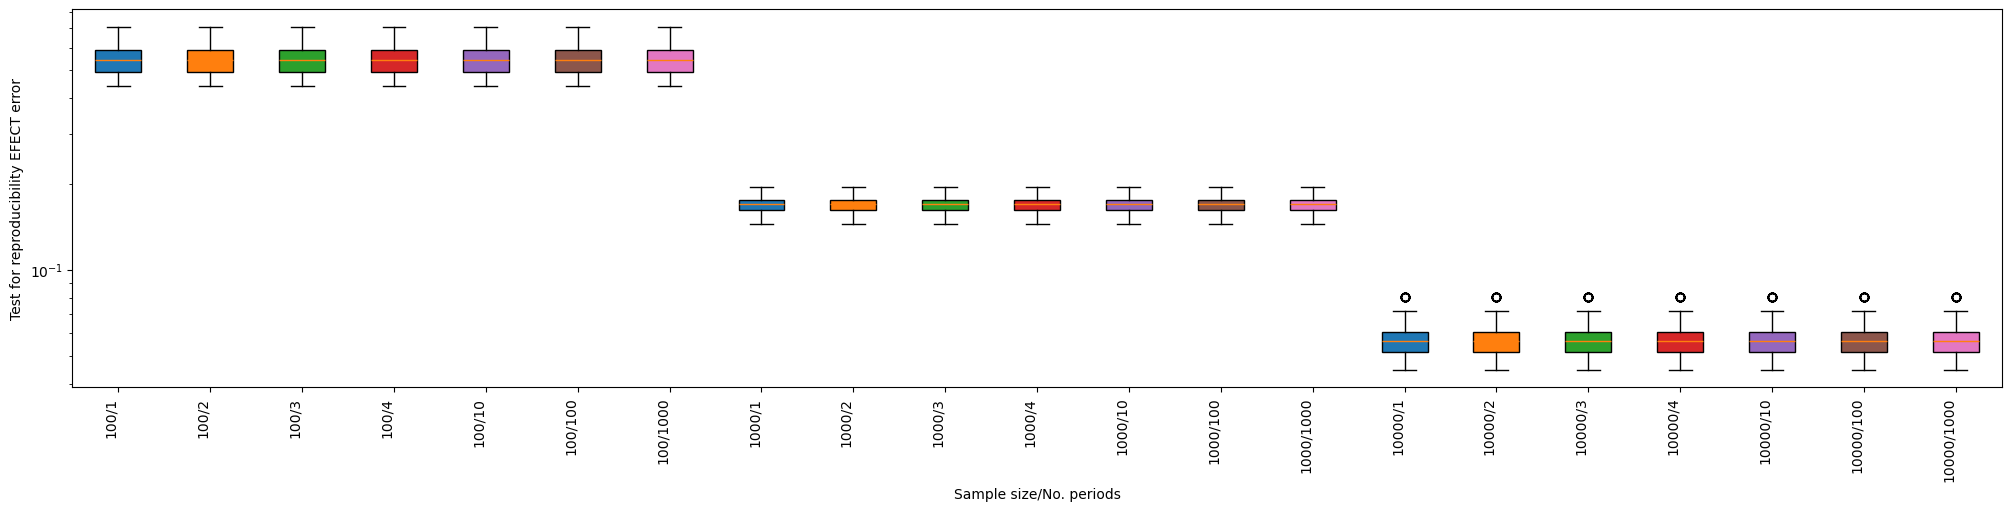

In [8]:
fig_ax = plt.subplots(1, 1, figsize=(20.0, 5.0), layout='compressed')

data = []
labels = []
for t in test_template.trials:
    for n, v in tests.items():
        data.append(v.ks_stats_sampling[t])
        labels.append(f'{t}/{n}')

bplot = fig_ax[1].boxplot(data, labels=labels, vert=True, patch_artist=True)
fig_ax[1].set_yscale('log')
fig_ax[1].set_xlabel('Sample size/No. periods')
fig_ax[1].set_ylabel('Test for reproducibility EFECT error')
fig_ax[1].set_xticklabels(fig_ax[1].get_xticklabels(), rotation=90, ha='right')

color_names = list(mcolors.TABLEAU_COLORS)
for i, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(color_names[i % len(periods)])

In [9]:
for k, v in tests.items():
    fp = f'proto_compare_periods_1_{k}.json'
    print('Saving output:', fp)
    v.save(fp)

Saving output: proto_compare_periods_1_1.json


Saving output: proto_compare_periods_1_2.json


Saving output: proto_compare_periods_1_3.json


Saving output: proto_compare_periods_1_4.json


Saving output: proto_compare_periods_1_10.json


Saving output: proto_compare_periods_1_100.json


Saving output: proto_compare_periods_1_1000.json
